/var/folders/jj/9j0c_6196zx24tx5jb3ngnym0000gn/T/ipykernel_36809/1749153890.py:33: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval = interval, period = PERIOD)
[*********************100%***********************]  1 of 1 completed


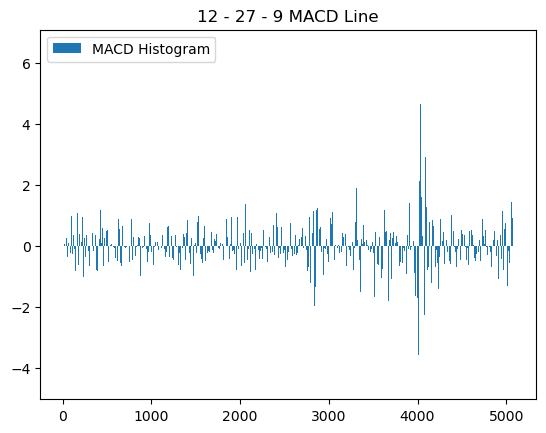

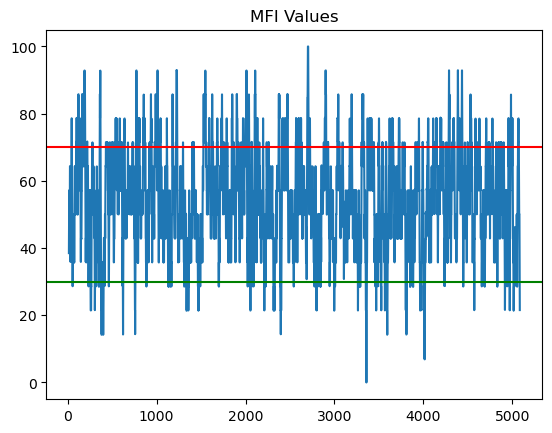

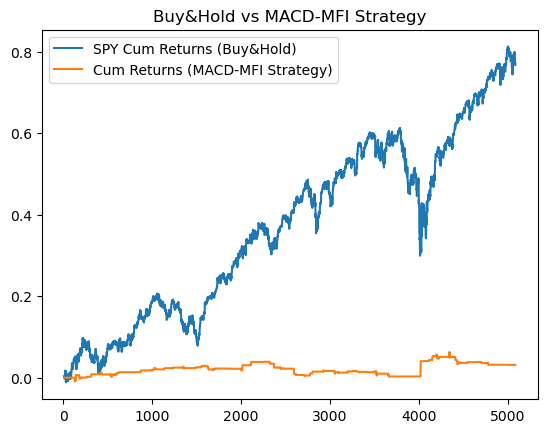

In [ ]:
import numpy as np 
import pandas as pd 
import yfinance as yf 
import matplotlib.pyplot as plt 

# Step 1: Ticker
TICKER = "SPY"

# Step 2: Price Behavior 
INTERVAL = "1h"
if INTERVAL == "1h":
    PERIOD = "730d"
else:
    PERIOD = "max"

# Step 3: MACD
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9

# Step 4: MFI 
MFI_LENGTH = 14
OVERBROUGHT = 70
OVERSOLD = 30

# Step 5: Data Subsection
LOOKBACK = 10000


def get_data(ticker = TICKER, interval = INTERVAL, lookback = LOOKBACK):
    
    # Step 1: Download Data
    df = yf.download(ticker, interval = interval, period = PERIOD)
    
    # Step 2: Select only Level 1 from Multilevel Column (MultiIndex)
    df.columns = df.columns.get_level_values(0)

    # Step 3: Simplifying df for Plots
    df = df.reset_index(drop=True)

    # Step 4: Return Subsect Data 
    return df.iloc[-lookback:, :]
        # -lookback: Get me the last lookback rows
        # : Get me all Columns

def add_MACD(df, fast = MACD_FAST, slow = MACD_SLOW, span = MACD_SPAN):
    
    # Step 1: Fast and Slow EMA Columns
    df[f"{fast}_ema"] = df["Close"].ewm(span = fast).mean()
    df[f"{slow}_ema"] = df["Close"].ewm(span = slow).mean()

    # Step 2: MACD Column (= Difference betwenn fast and slow ema)
    df["MACD"] = df[f"{fast}_ema"] - df[f"{slow}_ema"]

    # Step 3: MACD Signal (= Span Period)
    df["Signal"] = df[f"MACD"].ewm(span = span).mean()

    # Step 4: MACD Hist
    df["MACD_HIST"] = df[f"MACD"] - df["Signal"]

    # Step 5: Plot Histogram
    plt.figure()
    plt.bar(x=range(len(df)), height=df["MACD_HIST"])
        # Every Bar = Every Date in the Index
        # Direction: Bar (>0) --> Bullish vs. Bar (<0) --> Bearish
        # Strength: Bar (Tall) --> Strong Momentum vs. Bar (Short) --> Weak Momentum
    plt.title(f"{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Line")
    plt.legend(["MACD Histogram"])

    return df

def add_MFI(df, length = MFI_LENGTH):
    
    # Step 1: Build the MFI Index
    df["Average_Price"] = (df["High"]+df["Low"]+df["Close"])/3
    df["Money_Flow"] = df["Volume"]*df["Average_Price"]
    df["Pos_Flow"] = np.where(df["Average_Price"].diff()>0, df["Average_Price"], 0)
    df["Neg_Flow"] = np.where(df["Average_Price"].diff()<0, df["Average_Price"], 0)
    df["MFR"] = df["Pos_Flow"].rolling(window=length).sum() / df["Neg_Flow"].rolling(window=length).sum()
    df["MFI"] = (100 - 100 / (1 + df["MFR"]))

    # Step 2: Plot the MFI Index
    plt.figure()
    plt.plot(df["MFI"])
    plt.title("MFI Values")

    # Step 3: Draw Overbrought & Oversold Lines
    plt.axhline(OVERBROUGHT, color="red")
    plt.axhline(OVERSOLD, color="green")

    # Step 3: Return values without NA
    return df.dropna()

def add_MACD_strategy(df): 

    # Step 1: Long when Bullish Momentum, Short for Bearish Momentum
    df["MACD_Strategy"] = np.where(df["MACD_HIST"] > 0, 1, -1)

    # Step 2: Shift the signal to prevent lookahead bias - we can only understand Data after it happens:
    df["MACD_Strategy"] = df["MACD_Strategy"].shift(1)
    
    return df

def add_MFI_strategy(df, overbrought= OVERBROUGHT, oversold=OVERSOLD):
    df["MFI_Strategy"] = np.where(df["MFI"] > overbrought, -1, 
                    np.where(df["MFI"] < oversold, 1, 0))
    df["MFI_Strategy"] = df["MFI_Strategy"].shift(1)
    
    return df 

def add_confluence_strategy(df):
    
    # Step 1: Place trades, when those agree with each other/there is a confluence
    df["Confl_Strategy"] = df["MACD_Strategy"] + df["MFI_Strategy"]

    # Adjust for Simplicity
    df["Strategy"] = np.where(df["Confl_Strategy"] == 2, 1,
                    np.where(df["Confl_Strategy"] == -2, -1, 0))

    return df 

def test_strategy(df):
    
    # Step 1: Test Strategy 
    df["asset_cum_returns"] = (1 + df["Close"].pct_change()).cumprod() - 1 
    df["strategy_cum_returns"] = (1 + df["Close"].pct_change() * df["Strategy"]).cumprod() - 1

    # Step 2: Plot Returns
    plt.figure()
    plt.plot(df["asset_cum_returns"])
    plt.plot(df["strategy_cum_returns"])
    plt.legend([f"{TICKER} Cum Returns (Buy&Hold)", "Cum Returns (MACD-MFI Strategy)"])
    plt.title("Buy&Hold vs MACD-MFI Strategy")
    # In this graph we can recognize the compunding effect 

def main():
    df = get_data()
    df = add_MACD(df)
    df = add_MFI(df)
    df = add_MFI_strategy(df)
    df = add_MACD_strategy(df)
    df = add_confluence_strategy(df)
    df = test_strategy(df)

    return df

df = main()
df

In [9]:
# Testing Values
df["MACD_Strategy"].value_counts()

TypeError: 'NoneType' object is not subscriptable

In [ ]:
# Testing Values
df["MFI_Strategy"].value_counts()

MFI_Strategy
 0.0    723
-1.0    139
 1.0    124
Name: count, dtype: int64

In [ ]:
# Testing Values
df["Confl_Strategy"].value_counts()

Confl_Strategy
-1.0    382
 1.0    341
-2.0    129
 2.0    121
 0.0     13
Name: count, dtype: int64